# Data Analysis for project Olist
GitHub location: https://github.com/LarsTinnefeld/Olist-order-profile-analysis

Structure of this notebook:

1) Data Import and Preparation

2) Exploratory Data Analysis
- Units per order
- Lines per order
- Units per order line
- Pareto curve units
- Pareto curve order lines
- XYZ profile

3) 



---
## Data Preparation
### Importing libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime as dt
%matplotlib inline
sns.set_style("whitegrid")

### Importing datasets
This dataset stems from the previous data analysis (olist_ecom_analysis)

In [97]:
df_orders_consolidated = pd.read_csv('df_orders_consolidated.csv')

In [98]:
df_orders_consolidated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102422 entries, 0 to 102421
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     102422 non-null  int64  
 1   order_id                       102422 non-null  object 
 2   customer_id                    102422 non-null  object 
 3   order_status                   102422 non-null  object 
 4   order_purchase_timestamp       102422 non-null  object 
 5   order_approved_at              102408 non-null  object 
 6   order_delivered_carrier_date   101395 non-null  object 
 7   order_delivered_customer_date  102422 non-null  object 
 8   order_estimated_delivery_date  102422 non-null  object 
 9   date_ordinal                   102422 non-null  int64  
 10  shipping_time_delta            102422 non-null  int64  
 11  shipping_duration              102422 non-null  int64  
 12  estimated_duration            

Need to convert dates. Taking functin from previous analysis.

In [99]:
def convert_to_dt(dat, cols):
    '''Function takes in a dataframe name and date columns for conversion into datetime format'''
    for col in cols:
        dat[col] = pd.to_datetime(dat[col], format='%Y-%m-%d').dt.date

In [100]:
convert_to_dt(df_orders_consolidated, ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

---
# Exploratory data analysis / Oder profile analysis

---
## Order composition

In [101]:
df_order_class_comp = df_orders_consolidated.groupby([
    'order_id',
    'product_category_name'
    ]).agg({
        'product_id': 'count',
        'qty': 'sum',
        'price': 'sum',
        'order_line_cube_in_ltr': 'sum',
        'product_weight_g': 'sum',
        'estimated_duration': 'first',
        'shipping_duration': 'first',
        'shipping_time_delta': 'first',
        'order_purchase_timestamp': 'first'
        }).reset_index()

In [102]:
df_order_class_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98017 entries, 0 to 98016
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  98017 non-null  object 
 1   product_category_name     98017 non-null  object 
 2   product_id                98017 non-null  int64  
 3   qty                       98017 non-null  int64  
 4   price                     98017 non-null  float64
 5   order_line_cube_in_ltr    98017 non-null  float64
 6   product_weight_g          98017 non-null  float64
 7   estimated_duration        98017 non-null  int64  
 8   shipping_duration         98017 non-null  int64  
 9   shipping_time_delta       98017 non-null  int64  
 10  order_purchase_timestamp  98017 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 8.2+ MB


### Order profile (units per line, units per order, lines per order)

In [103]:
df_upo_lpo = df_orders_consolidated.groupby('order_id').agg({'qty': 'sum', 'product_id': 'count'}).reset_index()
df_upo_lpo.rename(columns = {'qty': 'units', 'product_id': 'lines'}, inplace = True)

In [104]:
df_upo_lpo

,order_id,units,lines
0,00010242fe8c5a6d1ba2dd792cb16214,1,1
1,00018f77f2f0320c557190d7a144bdd3,1,1
2,000229ec398224ef6ca0657da4fc703e,1,1
3,00024acbcdf0a6daa1e931b038114c75,1,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1
...,...,...,...
98659,fffc94f6ce00a00581880bf54a75a037,1,1
98660,fffcd46ef2263f404302a634eb57f7eb,1,1
98661,fffce4705a9662cd70adb13d4a31832d,1,1
98662,fffe18544ffabc95dfada21779c9644f,1,1


Plotting order profile charts

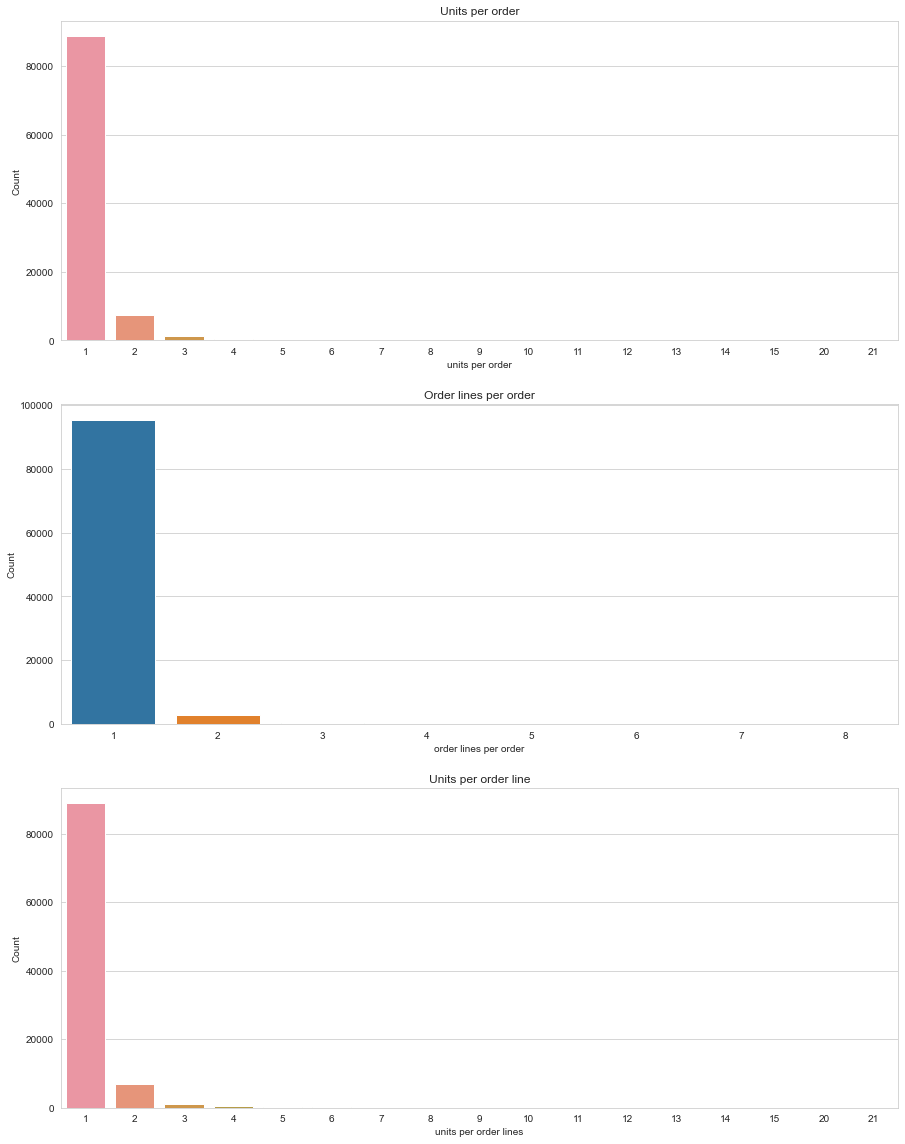

In [105]:
fig, ax = plt.subplots(3, 1, figsize = (15, 20))
sns.countplot(df_upo_lpo['units'], ax = ax[0])
sns.countplot(df_upo_lpo['lines'], ax = ax[1])
sns.countplot(df_order_class_comp['qty'], ax = ax[2])
ax[0].set(title = 'Units per order', xlabel = 'units per order', ylabel = 'Count')
ax[1].set(title = 'Order lines per order', xlabel = 'order lines per order', ylabel = 'Count')
ax[2].set(title = 'Units per order line', xlabel = 'units per order lines', ylabel = 'Count');

This looks typical e-commerce: mostly SIO (single item orders); two-step-order picking is an option to deal with this (batch pick, sort, pack)

### Generating pareto diagrams
We will base them on different metrics:
- units
- lines
- volume (cube)

Step 1: Creating a SKU list with aggregated values

In [106]:
df_orders_consolidated.columns

Index(['Unnamed: 0', 'order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'date_ordinal', 'shipping_time_delta',
       'shipping_duration', 'estimated_duration', 'product_id', 'qty',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_line_cube_in_ltr', 'price_round'],
      dtype='object')

In [107]:
df_SKUs = df_orders_consolidated\
    .groupby('product_id')\
    .agg({
        'qty': 'sum',
        'order_id': 'count',
        'order_line_cube_in_ltr': 'sum',
        'price': 'sum',
        'shipping_duration': 'mean'})

In [108]:
df_SKUs.rename(columns = {
        'qty': 'total_qty',
        'order_id': 'total_lines',
        'order_line_cube_in_ltr': 'total_cube',
        'shipping_duration': 'avg_ship_duration',
        'price': 'total_price'
        }, inplace = True)

In [109]:
# Adding counting column
df_SKUs['counter'] = 1

In [110]:
df_SKUs

,total_qty,total_lines,total_cube,total_price,avg_ship_duration,counter
product_id,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,1,1,5.120,101.65,17.0,1
00088930e925c41fd95ebfe695fd2655,1,1,14.300,129.90,11.0,1
0009406fd7479715e4bef61dd91f2462,1,1,23.625,229.00,16.0,1
000b8f95fcb9e0096488278317764d19,2,2,10.944,117.80,6.5,1
000d9be29b5207b54e86aa1b1ac54872,1,1,3.630,199.00,7.0,1
...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,2,2,31.500,229.98,9.0,1
fff81cc3158d2725c0655ab9ba0f712c,1,1,2.816,90.00,2.0,1
fff9553ac224cec9d15d49f5a263411f,1,1,2.288,32.00,10.0,1


Need to sort by quantity, then add a cummulating percent counter for unit based pareto.

In [111]:
def classifier(num):
    if num < 5:
        v_class = 'A'
    elif num < 20:
        v_class = 'B'
    elif num < 50:
        v_class = 'C'
    else:
        v_class = 'D'
    return v_class

In [112]:
def pareto_izer(dat, col):
    '''A function which adds prepares and executes a pareto curve for a given feature
    The dataframe is sorted in descending order for the given feature
    
    Inputs:     data frame, feature (column)
    
    Outputs:    column with cumulated, sorted veature values
                Pareto chart'''
    
    dat.sort_values(by = col, ascending = False, inplace = True) # sort by the feature   
    dat['cum_' + col] = dat[col].cumsum()/dat[col].sum()*100 # add or re-assign column whith the cummulated sum
    df_SKUs['v_class_' + col] = dat['cum_' + col].map(classifier) # add or re-assign SKU velocity class (ABC)

    # Plotting the chart
    f, ax = plt.subplots(figsize = (15, 7))
    ax = sns.lineplot(x = dat['counter'].cumsum()/dat['counter'].sum()*100, data = dat, y = ('cum_' + col))
    ax = plt.title('Pareto chart of % {} over % SKUs'. format(col))
    ax = plt.xlabel('Percentage SKUs')
    ax = plt.ylabel('Percentage {}'.format(col))
    return ax

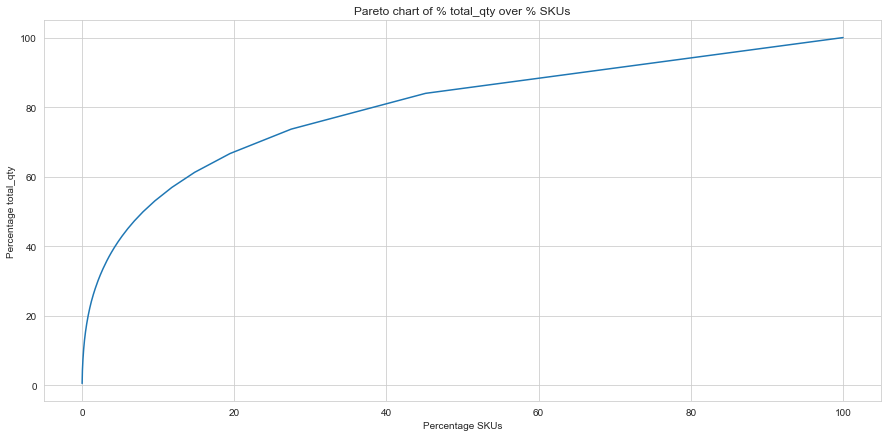

In [113]:
pareto_izer(df_SKUs, 'total_qty');

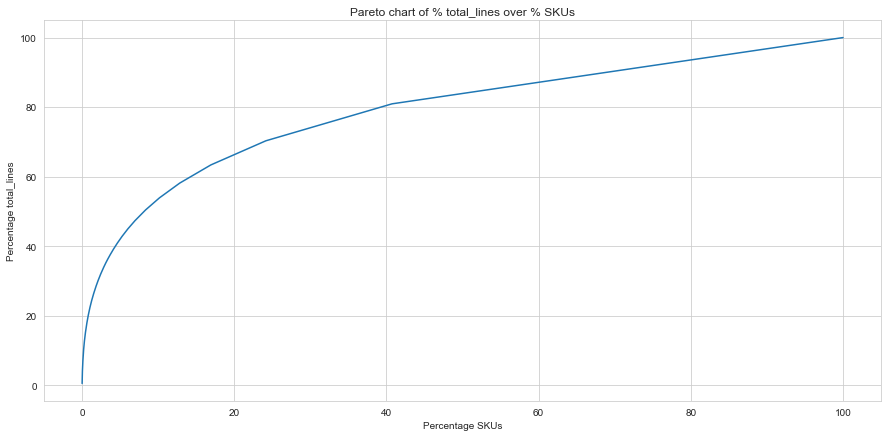

In [114]:
pareto_izer(df_SKUs, 'total_lines');

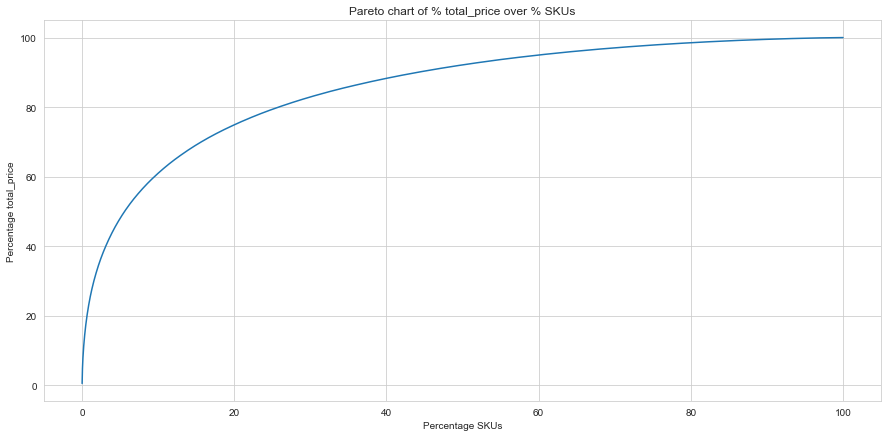

In [115]:
pareto_izer(df_SKUs, 'total_price');

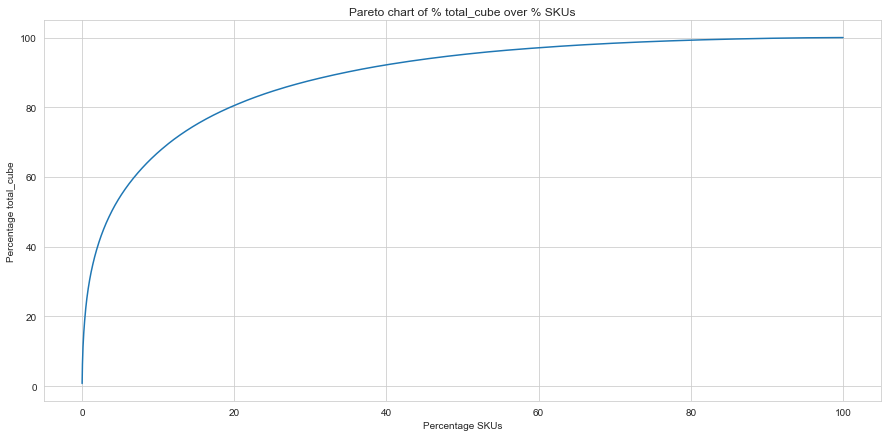

In [116]:
pareto_izer(df_SKUs, 'total_cube');

That looks like a good result. While the pareto charts of the total quantity and lines are following a 70/20 trend, the total price and total cube show a 80/20 curve.

In [117]:
df_SKUs

,total_qty,total_lines,total_cube,total_price,avg_ship_duration,counter,cum_total_qty,v_class_total_qty,cum_total_lines,v_class_total_lines,cum_total_price,v_class_total_price,cum_total_cube,v_class_total_cube
product_id,,,,,,,,,,,,,,
389d119b48cf3043d311335e499d9c6b,392,311,12763.520,16981.49,15.926045,1,1.678695,A,1.839449,A,7.317767,B,0.743309,A
99a4788cb24856965c36a24e339b6058,488,467,9760.000,41193.56,13.516060,1,0.901045,A,0.455957,A,1.951712,A,1.311702,A
422879e10f46682990de24d770e7f83d,484,352,9583.200,19265.00,15.946023,1,1.330706,A,1.220441,A,6.461199,B,1.869798,A
aca2eb7d00ea1a7b8ebd4e68314663af,527,431,7905.000,30730.60,12.044084,1,0.467833,A,0.876765,A,3.870010,A,2.330161,A
368c6c730842d78016ad823897a372db,388,291,7682.400,15776.30,15.384880,1,2.023134,A,2.422331,A,7.572857,B,2.777561,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71225f49be70df4297892f6a5fa62171,1,1,0.352,27.30,13.000000,1,98.945378,D,87.998672,D,99.578473,D,99.999932,D
2bc14ec16ec416f08e39fed48eda7f2d,1,1,0.352,34.30,14.000000,1,90.375243,D,97.066060,D,99.279255,D,99.999953,D
5a2a2db3896d33beec6828b898812ad5,1,1,0.352,27.30,5.000000,1,98.390547,D,85.897561,D,99.576116,D,99.999973,D


### Adding XYZ profile

Creating a dataframe which counts the number of active days for each SKU

In [118]:
SKUs_active_days = df_orders_consolidated\
    .groupby(['order_purchase_timestamp', 'product_id'])\
    .agg({'order_id': 'count'})\
    .reset_index()

In [119]:
SKUs_active_days = SKUs_active_days.groupby('product_id')\
    .agg({'order_purchase_timestamp': 'count'})\
    .sort_values(by='order_purchase_timestamp', ascending = False)\
    .reset_index()

In [120]:
SKUs_active_days.rename(columns = {'order_purchase_timestamp': 'active_days'}, inplace = True)

In [121]:
SKUs_active_days.head()

,product_id,active_days
0,99a4788cb24856965c36a24e339b6058,268
1,d1c427060a0f73f6b889a5c7c61f2ac4,202
2,422879e10f46682990de24d770e7f83d,196
3,2b4609f8948be18874494203496bc318,193
4,154e7e31ebfa092203795c972e5804a6,192


Adding the XYZ classification column

In [122]:
sample_timespan = df_orders_consolidated['order_purchase_timestamp'].max() - df_orders_consolidated['order_purchase_timestamp'].min()

In [123]:
def xyz_classifier(num):
    t_span = sample_timespan.days
    if num > (t_span * 2 / 3):
        activity_class = 'X'
    elif num > (t_span * 1 / 3):
        activity_class = 'Y'
    else:
        activity_class = 'Z'
        
    return activity_class

In [124]:
SKUs_active_days['XYZ_class'] = SKUs_active_days['active_days'].map(xyz_classifier)

In [125]:
SKUs_active_days

,product_id,active_days,XYZ_class
0,99a4788cb24856965c36a24e339b6058,268,Y
1,d1c427060a0f73f6b889a5c7c61f2ac4,202,Z
2,422879e10f46682990de24d770e7f83d,196,Z
3,2b4609f8948be18874494203496bc318,193,Z
4,154e7e31ebfa092203795c972e5804a6,192,Z
...,...,...,...
32944,69ac97e466e0d1329784803bb0d3319e,1,Z
32945,69abb160096c6a83656bff3c715a7497,1,Z
32946,69ab89fdb9df3f93455a0c52d6e4e3f0,1,Z
32947,69a7ee112e7b63892ad5db80e4c3277f,1,Z


Merging SKUs_active_days to df_SKUs

In [126]:
df_SKUs = df_SKUs.merge(SKUs_active_days, on = 'product_id')

In [127]:
df_SKUs.columns

Index(['product_id', 'total_qty', 'total_lines', 'total_cube', 'total_price',
       'avg_ship_duration', 'counter', 'cum_total_qty', 'v_class_total_qty',
       'cum_total_lines', 'v_class_total_lines', 'cum_total_price',
       'v_class_total_price', 'cum_total_cube', 'v_class_total_cube',
       'active_days', 'XYZ_class'],
      dtype='object')

Let's plot an XYZ diagram.

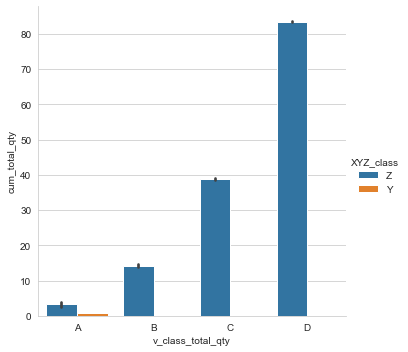

In [133]:
sns.catplot(data = df_SKUs, x = 'v_class_total_qty', y = 'cum_total_qty', kind = 'bar', aspect = 1, hue = 'XYZ_class')